# Convolutional Neural Networks

## Project goal

The goal of this project is write a dog breed identification application using convolutional neural networks. The resulting algorithm could be used as part of a mobile or web app. The code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.

![Sample Dog Output](figures/sample_dog_output.jpg)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the algorithm that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  

### The Road Ahead

The project consists of following steps:  

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write Algorithm to Classify Input Image
* [Step 6](#step6): Test the Algorithm

<a id='step0'></a>
## Step 0: Import Datasets

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


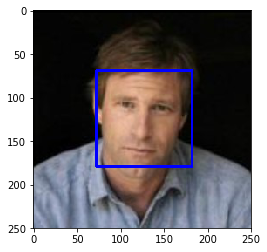

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

detected_human_human_faces = 0
for img_path in human_files_short:
    if face_detector(img_path):
        detected_human_human_faces += 1
print('Percentage of human faces detected as human', detected_human_human_faces)

detected_human_dog_faces = 0
for img_path in dog_files_short:
    if face_detector(img_path):
        detected_human_dog_faces += 1
print('Percentage of dog faces detected as human', detected_human_dog_faces)       

Percentage of human faces detected as human 96
Percentage of dog faces detected as human 17


## Load torch libraries

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that we take the time to learn how to appropriately preprocess tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def pretrained_model_predict(img_path, model, use_cuda):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    imsize = 224
    loader = transforms.Compose([transforms.RandomResizedCrop(imsize), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    image = Image.open(img_path)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    if use_cuda:        
        image = image.cuda()   

    output = model(image)

    _, preds_tensor = torch.max(output, 1) # convert output probabilities to predicted class
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return pred # predicted class index

###  Write a Dog Detector

While looking at the [ImageNet label dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).


In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, pretrained_model, use_cuda):
    
    dog_found = False
    if pretrained_model_predict(img_path, pretrained_model, use_cuda) >= 151 and 
       pretrained_model_predict(img_path, pretrained_model, use_cuda) <= 268:
            
        dog_found = True    
    
    return dog_found # true/false

### Assess the Dog Detector

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
pretrained_model = VGG16

detected_dog_human_faces = 0
for img_path in human_files_short:
    if dog_detector(img_path, pretrained_model, use_cuda):
        detected_dog_human_faces += 1
print('Percentage of human faces detected as dog', detected_dog_human_faces)

detected_dog_dog_faces = 0
for img_path in dog_files_short:
    if dog_detector(img_path, pretrained_model, use_cuda):
        detected_dog_dog_faces += 1
print('Percentage of dog faces detected as dog', detected_dog_dog_faces)


Percentage of human faces detected as dog 3
Percentage of dog faces detected as dog 93


We also explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc). 

In [10]:
resnet50 = models.resnet50(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    resnet50 = resnet50.cuda()
    
detected_dog_human_faces = 0
for img_path in human_files_short:
    if dog_detector(img_path, resnet50, use_cuda):
        detected_dog_human_faces += 1
print('Percentage of human faces detected as dog', detected_dog_human_faces)

detected_dog_dog_faces = 0
for img_path in dog_files_short:
    if dog_detector(img_path, VGG16, use_cuda):
        detected_dog_dog_faces += 1
print('Percentage of dog faces detected as dog', detected_dog_dog_faces)

Percentage of human faces detected as dog 0
Percentage of dog faces detected as dog 93


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN-based model from scratch that classifies dog breeds. In the next step, we will use an approach based on transfer learning.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="figures/Brittany_02625.jpg" width="100"> | <img src="figures/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="figures/Curly-coated_retriever_03896.jpg" width="200"> | <img src="figures/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="figures/Labrador_retriever_06457.jpg" width="150"> | <img src="figures/Labrador_retriever_06455.jpg" width="240"> | <img src="figures/Labrador_retriever_06449.jpg" width="220">

We need to note that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specify Data Loaders for the Dog Dataset

We write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). If we are interested in augmenting our training and/or validation data, we can use [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform_valid_test = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder('data/dogImages/train', transform=transform_train)
valid_data = datasets.ImageFolder('data/dogImages/valid', transform=transform_valid_test)
test_data = datasets.ImageFolder('data/dogImages/test', transform=transform_valid_test)

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
loaders = {};
loaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(loaders['train'])
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Inspired by the VGG_16 requirement of the input image to be of size 224x224, we decided on resizing the image to size 224. The following transforms are applied to the training images:
1. RandomHorizontalFlip(): Horizontally flip the image randomly with a probability of 0.5.
2. RandomResizedCrop(224): Sample various sized patches of the image whose size is distributed evenly between 8% and 100% of the image area and whose aspect ratio is chosen randomly between 3/4 and 4/3. Finally, resize the patch to 224x224.
3. Resize(256): Resize the image to 256x256
4. CenterCrop(224): Sample a square patch of size 224x224 from the center of the image
5. Normalize(): Normalize a tensor image with the provided mean and standard deviation.

Data augmentation helps prevent overfitting and helps with better generalization.



### Model Architecture

#### Basic VGG-like architecture

In [12]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # input: 3x224x224, output: 16x224x224
        self.pool1 = nn.MaxPool2d(2, 2)               # input: 16x224x224, output: 16x112x112
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # input: 16x112x112, output: 32x112x112
        self.pool2 = nn.MaxPool2d(2, 2)               # input: 32x112x112, output: 32x56x56
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # input: 32x56x56, output: 64x56x56
        self.pool3 = nn.MaxPool2d(2, 2)               # input: 64x56x56, output: 64x28x28
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # input: 64x28x28, output: 128x28x28
        self.pool4 = nn.MaxPool2d(2, 2)               # input: 128x28x28, output: 128x14x14
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)# input: 128x14x14, output: 256x14x14
        self.pool5 = nn.MaxPool2d(2, 2)               # input: 256x14x14, output: 256x7x7
        
        self.fc1 = nn.Linear(256 * 7 * 7, 500)        # linear layer (256 * 7 * 7 -> 500)
        
        self.fc2 = nn.Linear(500, 133)                # linear layer (500 -> 133)
        self.dropout = nn.Dropout(0.25)    
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)    
        
        return x

#### Basic VGG-like architecture with batch normalization (BN)

In [13]:
# define the CNN architecture
class Net_BN(nn.Module):
    def __init__(self):
        super(Net_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # input: 3x224x224, output: 16x224x224
        self.bn1   = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)               # input: 16x224x224, output: 16x112x112
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # input: 16x112x112, output: 32x112x112
        self.bn2   = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)               # input: 32x112x112, output: 32x56x56
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # input: 32x56x56, output: 64x56x56
        self.bn3   = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)               # input: 64x56x56, output: 64x28x28
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # input: 64x28x28, output: 128x28x28
        self.bn4   = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)               # input: 128x28x28, output: 128x14x14
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)# input: 128x14x14, output: 256x14x14
        self.bn5   = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)               # input: 256x14x14, output: 256x7x7
        
        self.fc1 = nn.Linear(256 * 7 * 7, 500)        # linear layer (256 * 7 * 7 -> 500)
        self.bn6   = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 133)                # linear layer (500 -> 133)
        
    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))
        x = self.bn5(self.pool5(F.relu(self.conv5(x))))
        x = x.view(-1, 256 * 7 * 7)
        x = self.bn6(F.relu(self.fc1(x)))
        x = self.fc2(x)        
        return x

#### Basic VGG-like architecture with global average pooling layer (GAP)

In [14]:
# define the CNN architecture
class Net_GAP(nn.Module):
    def __init__(self):
        super(Net_GAP, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # input: 3x224x224, output: 16x224x224
        self.pool1 = nn.MaxPool2d(2, 2)               # input: 16x224x224, output: 16x112x112
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # input: 16x112x112, output: 32x112x112
        self.pool2 = nn.MaxPool2d(2, 2)               # input: 32x112x112, output: 32x56x56
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # input: 32x56x56, output: 64x56x56
        self.pool3 = nn.MaxPool2d(2, 2)               # input: 64x56x56, output: 64x28x28
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # input: 64x28x28, output: 128x28x28
        self.pool4 = nn.MaxPool2d(2, 2)               # input: 128x28x28, output: 128x14x14
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)# input: 128x14x14, output: 256x14x14
        self.pool5 = nn.MaxPool2d(2, 2)               # input: 256x14x14, output: 256x7x7
        
        self.gap = nn.AdaptiveAvgPool2d(1)            # input: 256x7x7, output: 256x1x1
        self.fc1 = nn.Linear(256, 133)                # linear layer (256 -> 133)
  
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.gap(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)        
        return x

#### Basic VGG-like architecture with BN and GAP layer

In [15]:
# define the CNN architecture
class Net_GAP_BN(nn.Module):
    def __init__(self):
        super(Net_GAP_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # input: 3x224x224, output: 16x224x224
        self.pool1 = nn.MaxPool2d(2, 2)               # input: 16x224x224, output: 16x112x112
        self.bn1   = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # input: 16x112x112, output: 32x112x112
        self.pool2 = nn.MaxPool2d(2, 2)               # input: 32x112x112, output: 32x56x56
        self.bn2   = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # input: 32x56x56, output: 64x56x56
        self.pool3 = nn.MaxPool2d(2, 2)               # input: 64x56x56, output: 64x28x28
        self.bn3   = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # input: 64x28x28, output: 128x28x28
        self.pool4 = nn.MaxPool2d(2, 2)               # input: 128x28x28, output: 128x14x14
        self.bn4   = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)# input: 128x14x14, output: 256x14x14
        self.pool5 = nn.MaxPool2d(2, 2)               # input: 256x14x14, output: 256x7x7
        self.bn5   = nn.BatchNorm2d(256)
        
        self.gap = nn.AdaptiveAvgPool2d(1)            # input: 256x7x7, output: 256x1x1
        self.fc1 = nn.Linear(256, 133)                # linear layer (256 -> 133)
  
    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))
        x = self.bn5(self.pool5(F.relu(self.conv5(x))))
        x = self.gap(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)        
        return x

#### Deep VGG-like architecture with BN and GAP

In [16]:
# define the CNN architecture
class Net_deep_GAP_BN(nn.Module):
    def __init__(self):
        super(Net_deep_GAP_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # input: 3x224x224, output: 16x224x224
        self.pool1 = nn.MaxPool2d(2, 2)               # input: 16x224x224, output: 16x112x112
        self.bn1   = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # input: 16x112x112, output: 32x112x112
        self.pool2 = nn.MaxPool2d(2, 2)               # input: 32x112x112, output: 32x56x56
        self.bn2   = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # input: 32x56x56, output: 64x56x56
        self.pool3 = nn.MaxPool2d(2, 2)               # input: 64x56x56, output: 64x28x28
        self.bn3   = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # input: 64x28x28, output: 128x28x28
        self.pool4 = nn.MaxPool2d(2, 2)               # input: 128x28x28, output: 128x14x14
        self.bn4   = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)# input: 128x14x14, output: 256x14x14
        self.pool5 = nn.MaxPool2d(2, 2)               # input: 256x14x14, output: 256x7x7
        self.bn5   = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)# input: 256x7x7, output: 512x7x7
        self.bn6   = nn.BatchNorm2d(512)
        
        self.gap = nn.AdaptiveAvgPool2d(1)            # input: 512x7x7, output: 512x1x1
        self.fc1 = nn.Linear(512, 133)                # linear layer (512 -> 133)
  
    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))
        x = self.bn5(self.pool5(F.relu(self.conv5(x))))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.gap(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc1(x)        
        return x

We took the following steps:
1. We started with a light weight VGG-like architecture called Net() with alternate conv, relu, pool layers with couple of fully connected (FC) layers towards the end. We also added small dropouts in the FC layers for regularization.
2. Set the loss function to cross entropy loss and the optimization function to Adam optimizer
3. Trained the network for 100 epochs at learning rate of 0.001. Saved the model with lowest validation loss.
4. Evaluated the performance on the test data.
5. We added batch normalization (BN) after every pooling layer and before the final FC layer to Net() architecture to create an architecture called Net_BN(). We removed all the dropout layers. We then ran steps 2 to 4. The BN layers were added before inputs to each layer to normalize and condition the inputs, for regularization, and for better generalization.
6. We replaced the 2nd last FC layer with a global average pooling (GAP) layer in the Net() architecture to create an architecture called Net_GAP(). We removed all the dropout layers. We then ran steps 2 to 4. The GAP layer was added to drastically reduce the number of parameters, for regularization, and for better generalization.
7. We took Net_GAP() architecture and added BN to create an architecture called Net_GAP_BN(). We then ran steps 2 to 4. The BN and GAP layers were added together to get the benefits of both.
8. We took Net_GAP_BN() architecture and added a new conv layer with 512 channels to create a deeper architecture called Net_deep_GAP_BN(). We then ran steps 2 to 4. The new conv layer was added to improve the fitting on the training data.

We found the best performance with Net_deep_GAP_BN() architecture. We trained the network for 50 iterations at the learning rate of 0.001 and thereafter 50 more iterations at the learning rate of 0.0001. We found the 72% performance on the test data.

In addition, we tried lots of other options such as: 
1. Compared adding BN before and after activation. We found the best place to add BN is after all the layers like conv, activation, pool layers in the current group, and before the first following conv layer.
2. Added dropout to Net_deep_GAP_BN() architecture. We found the network taking too long to train.
3. Added 2D dropout after the BN steps and 1D dropout before and after the FC layer. The training was slow and the performance was not good.
4. We tried much larger architecture similar to VGG16 but with GAP, BN, and dropout layers. The training was very slow. We could get upto 80% test performance after 300 iterations.
5. We tried significantly larger data augmentation scheme with the Net_deep_GAP_BN() architecture. The training was slow and the performance was not good.
6. We tried replacing pooling layers with stride 2 convolution in the Net_deep_GAP_BN() architecture. We saw the performance deteriorate significantly.
7. We tried replacing ReLU activation with LeakyReLU activation. We did not see any improvement.
8. We tried other optimizers like SGD and found no improvement in performance.


### Train and Validate the Model

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_loss_coll = []
    valid_loss_coll = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        train_correct = 0.
        train_total = 0.
        
        valid_loss = 0.0
        valid_correct = 0.
        valid_total = 0.        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (train_data, train_target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                train_data, train_target = train_data.cuda(), train_target.cuda()
            # clear the gradients of all optimized variables    
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            train_output = model(train_data)
            # calculate the batch loss
            loss = criterion(train_output, train_target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update total training loss
            train_loss += loss.item()*train_data.size(0)            
            # convert output logits to predicted class
            train_pred = train_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(train_pred.eq(train_target.data.view_as(train_pred))).cpu().numpy())
            train_total += train_data.size(0)
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for val_batch_idx, (val_data, val_target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                val_data, val_target = val_data.cuda(), val_target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            val_output = model(val_data)
            # calculate the batch loss
            val_loss = criterion(val_output, val_target)
            # update total validation loss 
            valid_loss += val_loss.item()*val_data.size(0)
            # convert output logits to predicted class
            valid_pred = val_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(valid_pred.eq(val_target.data.view_as(valid_pred))).cpu().numpy())
            valid_total += val_data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        train_acc = 100. * train_correct / train_total
        valid_acc = 100. * valid_correct / valid_total
            
        # print training/validation statistics 
        if epoch % 5 == 0:
            print('Epoch: {} \tTrain Loss: {:.6f} \tValid Loss: {:.6f} \tTrain Acc: {:.2f} \tValid Acc: {:.2f}'.format(
                epoch, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc
                ))
        
        ## Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss   
            
        train_loss_coll.append(train_loss)
        valid_loss_coll.append(valid_loss)
            
    # return trained model
    return model, train_loss_coll, valid_loss_coll

### Test the Model

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output logits to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
# Basic network
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

# train the model
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
model_scratch, train_loss_coll, valid_loss_coll = train(100, loaders, model_scratch, optimizer_scratch, 
                                                        criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Validation loss decreased (inf --> 4.874906).  Saving model ...
Validation loss decreased (4.874906 --> 4.671670).  Saving model ...
Validation loss decreased (4.671670 --> 4.593451).  Saving model ...
Validation loss decreased (4.593451 --> 4.576399).  Saving model ...
Epoch: 5 	Train Loss: 4.604167 	Valid Loss: 4.479142 	Train Acc: 2.92 	Valid Acc: 3.23
Validation loss decreased (4.576399 --> 4.479142).  Saving model ...
Validation loss decreased (4.479142 --> 4.420441).  Saving model ...
Validation loss decreased (4.420441 --> 4.400971).  Saving model ...
Validation loss decreased (4.400971 --> 4.358760).  Saving model ...
Validation loss decreased (4.358760 --> 4.285988).  Saving model ...
Epoch: 10 	Train Loss: 4.373774 	Valid Loss: 4.165752 	Train Acc: 4.45 	Valid Acc: 6.47
Validation loss decreased (4.285988 --> 4.165752).  Saving model ...
Validation loss decreased (4.165752 --> 4.146511).  Saving model ...
Validation loss decreased (4.146511 --> 4.019453).  Saving model ...
Va

In [21]:
# With batch normalization

# instantiate the CNN
model_scratch_BN = Net_BN()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_BN.cuda()

# train the model
criterion_scratch_BN = nn.CrossEntropyLoss()
optimizer_scratch_BN = optim.Adam(model_scratch_BN.parameters(), lr=0.001)
model_scratch_BN, train_loss_coll_BN, valid_loss_coll_BN = train(100, loaders, model_scratch_BN, optimizer_scratch_BN, 
                                                                 criterion_scratch_BN, use_cuda, 'model_scratch_BN.pt')

# load the model that got the best validation accuracy
model_scratch_BN.load_state_dict(torch.load('model_scratch_BN.pt'))

# call test function    
test(loaders, model_scratch_BN, criterion_scratch_BN, use_cuda)

Validation loss decreased (inf --> 4.544184).  Saving model ...
Validation loss decreased (4.544184 --> 4.170557).  Saving model ...
Validation loss decreased (4.170557 --> 3.901508).  Saving model ...
Validation loss decreased (3.901508 --> 3.815202).  Saving model ...
Epoch: 5 	Train Loss: 3.868753 	Valid Loss: 3.721022 	Train Acc: 10.76 	Valid Acc: 12.46
Validation loss decreased (3.815202 --> 3.721022).  Saving model ...
Validation loss decreased (3.721022 --> 3.534368).  Saving model ...
Validation loss decreased (3.534368 --> 3.385950).  Saving model ...
Validation loss decreased (3.385950 --> 3.194983).  Saving model ...
Validation loss decreased (3.194983 --> 3.063773).  Saving model ...
Epoch: 10 	Train Loss: 3.160952 	Valid Loss: 2.965617 	Train Acc: 23.04 	Valid Acc: 25.51
Validation loss decreased (3.063773 --> 2.965617).  Saving model ...
Validation loss decreased (2.965617 --> 2.947377).  Saving model ...
Validation loss decreased (2.947377 --> 2.726241).  Saving model ..

In [22]:
# Basic network with GAP (global average pooling) layer

# instantiate the CNN
model_scratch_GAP = Net_GAP()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_GAP.cuda()

# train the model
criterion_scratch_GAP = nn.CrossEntropyLoss()
optimizer_scratch_GAP = optim.Adam(model_scratch_GAP.parameters(), lr=0.001)
model_scratch_GAP, train_loss_coll_GAP, valid_loss_coll_GAP = train(100, loaders, model_scratch_GAP, optimizer_scratch_GAP, 
                                                              criterion_scratch_GAP, use_cuda, 'model_scratch_GAP.pt')

# load the model that got the best validation accuracy
model_scratch_GAP.load_state_dict(torch.load('model_scratch_GAP.pt'))

# call test function    
test(loaders, model_scratch_GAP, criterion_scratch_GAP, use_cuda)

Validation loss decreased (inf --> 4.810369).  Saving model ...
Validation loss decreased (4.810369 --> 4.629372).  Saving model ...
Validation loss decreased (4.629372 --> 4.524059).  Saving model ...
Validation loss decreased (4.524059 --> 4.346849).  Saving model ...
Epoch: 5 	Train Loss: 4.302784 	Valid Loss: 4.199351 	Train Acc: 5.19 	Valid Acc: 6.83
Validation loss decreased (4.346849 --> 4.199351).  Saving model ...
Validation loss decreased (4.199351 --> 4.091623).  Saving model ...
Validation loss decreased (4.091623 --> 3.956710).  Saving model ...
Validation loss decreased (3.956710 --> 3.719725).  Saving model ...
Epoch: 10 	Train Loss: 3.720020 	Valid Loss: 3.700962 	Train Acc: 12.32 	Valid Acc: 12.93
Validation loss decreased (3.719725 --> 3.700962).  Saving model ...
Validation loss decreased (3.700962 --> 3.619266).  Saving model ...
Validation loss decreased (3.619266 --> 3.436226).  Saving model ...
Validation loss decreased (3.436226 --> 3.381728).  Saving model ...


In [23]:
# Basic network with GAP (global average pooling) layer and batch normalization

# instantiate the CNN
model_scratch_GAP_BN = Net_GAP_BN()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_GAP_BN.cuda()

# train the model
criterion_scratch_GAP_BN = nn.CrossEntropyLoss()
optimizer_scratch_GAP_BN = optim.Adam(model_scratch_GAP_BN.parameters(), lr=0.001)
model_scratch_GAP_BN, train_loss_coll_GAP_BN, valid_loss_coll_GAP_BN = train(100, loaders, model_scratch_GAP_BN, 
                                                                             optimizer_scratch_GAP_BN, 
                                                                             criterion_scratch_GAP_BN, use_cuda, 
                                                                             'model_scratch_GAP_BN.pt')

# load the model that got the best validation accuracy
model_scratch_GAP_BN.load_state_dict(torch.load('model_scratch_GAP_BN.pt'))

# call test function    
test(loaders, model_scratch_GAP_BN, criterion_scratch_GAP_BN, use_cuda)

Validation loss decreased (inf --> 4.460149).  Saving model ...
Validation loss decreased (4.460149 --> 4.214677).  Saving model ...
Validation loss decreased (4.214677 --> 3.923872).  Saving model ...
Validation loss decreased (3.923872 --> 3.744176).  Saving model ...
Epoch: 5 	Train Loss: 3.780625 	Valid Loss: 3.578543 	Train Acc: 12.59 	Valid Acc: 13.89
Validation loss decreased (3.744176 --> 3.578543).  Saving model ...
Validation loss decreased (3.578543 --> 3.436047).  Saving model ...
Validation loss decreased (3.436047 --> 3.340138).  Saving model ...
Validation loss decreased (3.340138 --> 3.134604).  Saving model ...
Validation loss decreased (3.134604 --> 3.029504).  Saving model ...
Epoch: 10 	Train Loss: 3.118034 	Valid Loss: 3.164240 	Train Acc: 23.58 	Valid Acc: 23.95
Validation loss decreased (3.029504 --> 2.822685).  Saving model ...
Validation loss decreased (2.822685 --> 2.589438).  Saving model ...
Validation loss decreased (2.589438 --> 2.520052).  Saving model ..

In [24]:
# Deep network with GAP (global average pooling) layer and batch normalization

# instantiate the CNN
model_scratch_deep_GAP_BN = Net_deep_GAP_BN()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_deep_GAP_BN.cuda()

# train the model
criterion_scratch_deep_GAP_BN = nn.CrossEntropyLoss()
optimizer_scratch_deep_GAP_BN = optim.Adam(model_scratch_deep_GAP_BN.parameters(), lr=0.001)
model_scratch_deep_GAP_BN, train_loss_coll_deep_GAP_BN_1, valid_loss_coll_deep_GAP_BN_1 = train(50, loaders, 
                                                                                            model_scratch_deep_GAP_BN, 
                                                                                            optimizer_scratch_deep_GAP_BN, 
                                                                                            criterion_scratch_deep_GAP_BN, 
                                                                                            use_cuda, 
                                                                                            'model_scratch_deep_GAP_BN.pt')

# load the model that got the best validation accuracy
model_scratch_deep_GAP_BN.load_state_dict(torch.load('model_scratch_deep_GAP_BN.pt'))

# call test function    
test(loaders, model_scratch_deep_GAP_BN, criterion_scratch_deep_GAP_BN, use_cuda)

Validation loss decreased (inf --> 4.389610).  Saving model ...
Validation loss decreased (4.389610 --> 4.280922).  Saving model ...
Validation loss decreased (4.280922 --> 4.113422).  Saving model ...
Validation loss decreased (4.113422 --> 3.751862).  Saving model ...
Epoch: 5 	Train Loss: 3.804927 	Valid Loss: 3.599489 	Train Acc: 11.23 	Valid Acc: 11.86
Validation loss decreased (3.751862 --> 3.599489).  Saving model ...
Validation loss decreased (3.599489 --> 3.337231).  Saving model ...
Validation loss decreased (3.337231 --> 3.074191).  Saving model ...
Validation loss decreased (3.074191 --> 2.991803).  Saving model ...
Validation loss decreased (2.991803 --> 2.839803).  Saving model ...
Epoch: 10 	Train Loss: 3.032306 	Valid Loss: 2.753022 	Train Acc: 25.72 	Valid Acc: 29.94
Validation loss decreased (2.839803 --> 2.753022).  Saving model ...
Validation loss decreased (2.753022 --> 2.483419).  Saving model ...
Validation loss decreased (2.483419 --> 2.315292).  Saving model ..

In [25]:
model_scratch_deep_GAP_BN.load_state_dict(torch.load('model_scratch_deep_GAP_BN.pt'))

# train the model
criterion_scratch_deep_GAP_BN = nn.CrossEntropyLoss()
optimizer_scratch_deep_GAP_BN = optim.Adam(model_scratch_deep_GAP_BN.parameters(), lr=0.0001)
model_scratch_deep_GAP_BN, train_loss_coll_deep_GAP_BN_2, valid_loss_coll_deep_GAP_BN_2 = train(50, loaders, 
                                                                                            model_scratch_deep_GAP_BN, 
                                                                                            optimizer_scratch_deep_GAP_BN, 
                                                                                            criterion_scratch_deep_GAP_BN, 
                                                                                            use_cuda, 
                                                                                            'model_scratch_deep_GAP_BN.pt')

# load the model that got the best validation accuracy
model_scratch_deep_GAP_BN.load_state_dict(torch.load('model_scratch_deep_GAP_BN.pt'))

# call test function    
test(loaders, model_scratch_deep_GAP_BN, criterion_scratch_deep_GAP_BN, use_cuda)

Validation loss decreased (inf --> 1.328440).  Saving model ...
Validation loss decreased (1.328440 --> 1.318890).  Saving model ...
Validation loss decreased (1.318890 --> 1.308531).  Saving model ...
Epoch: 5 	Train Loss: 0.881560 	Valid Loss: 1.288438 	Train Acc: 78.14 	Valid Acc: 65.99
Validation loss decreased (1.308531 --> 1.288438).  Saving model ...
Validation loss decreased (1.288438 --> 1.269279).  Saving model ...
Epoch: 10 	Train Loss: 0.864716 	Valid Loss: 1.287180 	Train Acc: 77.37 	Valid Acc: 67.07
Epoch: 15 	Train Loss: 0.794644 	Valid Loss: 1.279575 	Train Acc: 79.90 	Valid Acc: 65.15
Epoch: 20 	Train Loss: 0.777436 	Valid Loss: 1.311553 	Train Acc: 79.91 	Valid Acc: 65.51
Epoch: 25 	Train Loss: 0.786066 	Valid Loss: 1.274627 	Train Acc: 80.00 	Valid Acc: 65.27
Epoch: 30 	Train Loss: 0.777930 	Valid Loss: 1.305167 	Train Acc: 80.39 	Valid Acc: 66.35
Validation loss decreased (1.269279 --> 1.258258).  Saving model ...
Epoch: 35 	Train Loss: 0.737997 	Valid Loss: 1.28311

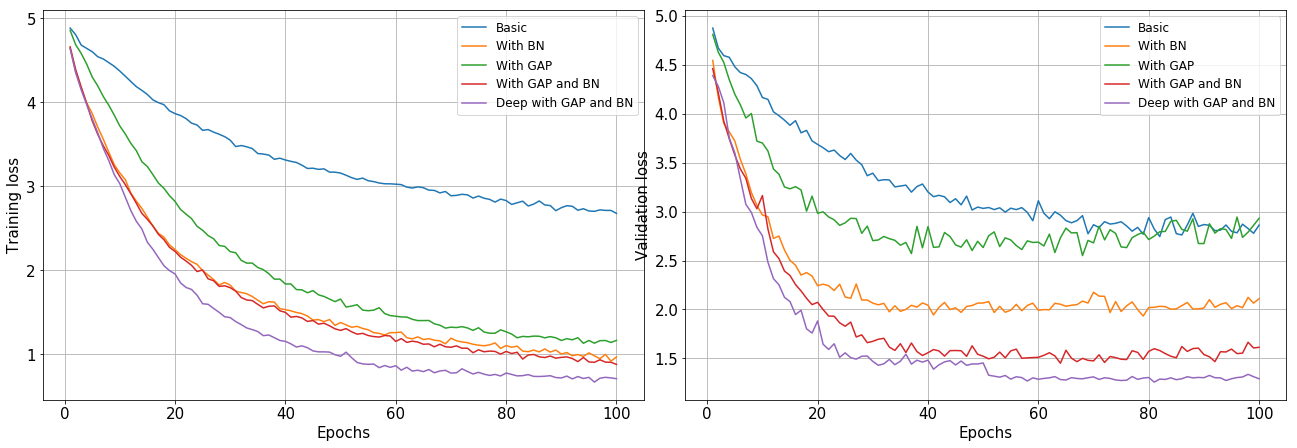

In [73]:
train_loss_coll_deep_GAP_BN = train_loss_coll_deep_GAP_BN_1 + train_loss_coll_deep_GAP_BN_2
valid_loss_coll_deep_GAP_BN = valid_loss_coll_deep_GAP_BN_1 + valid_loss_coll_deep_GAP_BN_2


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

epochs = range(1,101)

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
fsize = 15

ax1.plot(epochs, train_loss_coll, label='Basic')
ax1.plot(epochs, train_loss_coll_BN, label='With BN')
ax1.plot(epochs, train_loss_coll_GAP, label='With GAP')
ax1.plot(epochs, train_loss_coll_GAP_BN, label='With GAP and BN')
ax1.plot(epochs, train_loss_coll_deep_GAP_BN, label='Deep with GAP and BN')
ax1.set_xlabel('Epochs', fontsize = fsize)
ax1.set_ylabel('Training loss', fontsize = fsize)
ax1.legend()
ax1.tick_params(labelsize = fsize)
ax1.grid()
ax1.legend(fontsize = 12)

ax2.plot(epochs, valid_loss_coll, label='Basic')
ax2.plot(epochs, valid_loss_coll_BN, label='With BN')
ax2.plot(epochs, valid_loss_coll_GAP, label='With GAP')
ax2.plot(epochs, valid_loss_coll_GAP_BN, label='With GAP and BN')
ax2.plot(epochs, valid_loss_coll_deep_GAP_BN, label='Deep with GAP and BN')
ax2.set_xlabel('Epochs', fontsize = fsize)
ax2.set_ylabel('Validation loss', fontsize = fsize)
ax2.legend()
ax2.tick_params(labelsize = fsize)
ax2.grid()
ax2.legend(fontsize = 12)

plt.savefig('Network_architectures.png', bbox_inches='tight', orientation='landscape', dpi=300)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images. We will reuse the data loaders that we created earlier. 

### Model Architecture

In [28]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [29]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [30]:
model_transfer.fc = nn.Linear(in_features=2048, out_features=133, bias=True)
# Freeze training for all layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Unfreeze training for fully connected (fc) layers   
for param in model_transfer.fc.parameters():
    param.requires_grad = True

In [31]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


We executed the following steps to do transfer learning:
1. Take a canonical architecture like Resnet50 which has performed very well on image recognition problems such as ImageNet challenge.
2. Replace the fully connected (FC) layer of size (2048, 1000) with a FC layer of size (2048, 133)
3. Initialize the new FC layer with randomized weights
4. Freeze all the layers except the FC layer
5. Set the loss function to cross entropy loss and the optimization function to Adam optimizer
5. Train the network for 15 epochs at learning rate of 0.001. Save the model with lowest validation loss.
6. Train the network further for 35 more epochs at lower learning rate of 0.0001. Save the model with lowest validation loss.
7. Use the model with the lowest validation loss.
8. Evaluate the performance on the test data.

### Train and Validate the Model

In [32]:
if use_cuda:
    model_transfer = model_transfer.cuda()

# Set the loss and the optimization function
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

# train the model
model_transfer, train_loss_coll_tr, valid_loss_coll_tr = train(15, loaders, model_transfer, optimizer_transfer, 
                                                               criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the lowest validation loss
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# Test the performance of the model with the lowest validation loss on the test data
test(loaders, model_transfer, criterion_transfer, use_cuda)

Validation loss decreased (inf --> 0.801459).  Saving model ...
Validation loss decreased (0.801459 --> 0.633566).  Saving model ...
Validation loss decreased (0.633566 --> 0.567574).  Saving model ...
Validation loss decreased (0.567574 --> 0.547722).  Saving model ...
Epoch: 5 	Train Loss: 0.951965 	Valid Loss: 0.543049 	Train Acc: 72.83 	Valid Acc: 83.71
Validation loss decreased (0.547722 --> 0.543049).  Saving model ...
Validation loss decreased (0.543049 --> 0.531565).  Saving model ...
Validation loss decreased (0.531565 --> 0.477787).  Saving model ...
Validation loss decreased (0.477787 --> 0.470338).  Saving model ...
Epoch: 10 	Train Loss: 0.877329 	Valid Loss: 0.480101 	Train Acc: 75.39 	Valid Acc: 85.51
Validation loss decreased (0.470338 --> 0.464429).  Saving model ...
Epoch: 15 	Train Loss: 0.794741 	Valid Loss: 0.569395 	Train Acc: 78.13 	Valid Acc: 83.83
Test Loss: 0.526821


Test Accuracy: 85% (718/836)


In [33]:
# Train further at a lower learning rate

# Load the model weights with the lowest validation loss
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# Set the loss and the optimization function
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0001)

# train the model further
model_transfer, train_loss_coll_tr_1, valid_loss_coll_tr_1 = train(35, loaders, model_transfer, optimizer_transfer, 
                                                                   criterion_transfer, use_cuda, 'model_transfer.pt')
# load the model that got the lowest validation loss
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# Test the performance of the model with the lowest validation loss on the test data
test(loaders, model_transfer, criterion_transfer, use_cuda)

Validation loss decreased (inf --> 0.370042).  Saving model ...
Validation loss decreased (0.370042 --> 0.363682).  Saving model ...
Validation loss decreased (0.363682 --> 0.358630).  Saving model ...
Validation loss decreased (0.358630 --> 0.349050).  Saving model ...
Epoch: 5 	Train Loss: 0.555583 	Valid Loss: 0.356784 	Train Acc: 84.64 	Valid Acc: 88.26
Validation loss decreased (0.349050 --> 0.339956).  Saving model ...
Epoch: 10 	Train Loss: 0.527071 	Valid Loss: 0.341360 	Train Acc: 85.40 	Valid Acc: 88.98
Epoch: 15 	Train Loss: 0.512768 	Valid Loss: 0.356509 	Train Acc: 85.57 	Valid Acc: 88.86
Epoch: 20 	Train Loss: 0.536787 	Valid Loss: 0.360589 	Train Acc: 84.67 	Valid Acc: 88.02
Epoch: 25 	Train Loss: 0.502247 	Valid Loss: 0.335959 	Train Acc: 85.84 	Valid Acc: 88.50
Validation loss decreased (0.339956 --> 0.335959).  Saving model ...
Validation loss decreased (0.335959 --> 0.329003).  Saving model ...
Epoch: 30 	Train Loss: 0.494261 	Valid Loss: 0.348611 	Train Acc: 85.96 	

### Predict Dog Breed with the model based on transfer learning

In [46]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_dog_breed_using_tl_model(img_path, model, use_cuda, class_names):
    # load the image and return the predicted breed
    imsize = 224
    loader = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(imsize),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    image = Image.open(img_path)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    if use_cuda:        
        image = image.cuda()   

    output = model(image)

    _, preds_tensor = torch.max(output, 1) # convert output probabilities to predicted class
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]


---
<a id='step5'></a>
## Step 5: Dog breed classification algorithm

Our algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We will use the `face_detector` and `human_detector` functions developed above. 

In [64]:
def run_app(img_path):
    
    title_message = 'You are neither human nor a dog!'
    
    if face_detector(img_path):
        dog_breed = predict_dog_breed_using_tl_model(img_path, model_transfer, use_cuda, class_names)
        title_message = 'Hello human!\nYou look like ...\n' + dog_breed
        
    if dog_detector(img_path, VGG16, use_cuda):
        dog_breed = predict_dog_breed_using_tl_model(img_path, model_transfer, use_cuda, class_names)
        title_message = 'Hello dog!\nYour predicted breed is ...\n' + dog_breed       
    
    plt.figure()
    plt.imshow(Image.open(img_path))
    plt.title(title_message)
    plt.show()  

---
<a id='step6'></a>
## Step 6: Testing the algorithm

We will test our algorithm on six sample images.  The performance is better than we expected. However, we used a model based on transfer learning. The following could help: 
1. The data set was extremely challenging with only ~62 images per dog breed category. We need a much larger dataset with more number of samples per category.
2. We found the data augmentation to be only marginally helpful. More research can be done in this area.
3. We tried different variants of our base light VGG-like architecuture. This is definitely an area of improvement.

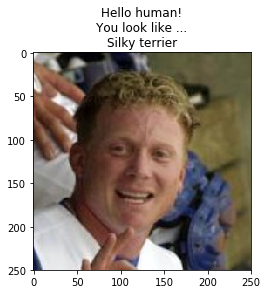

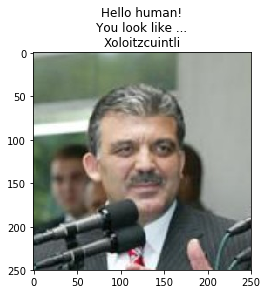

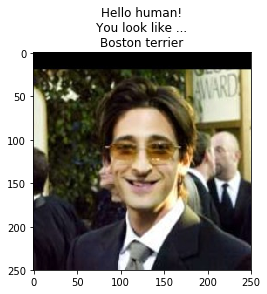

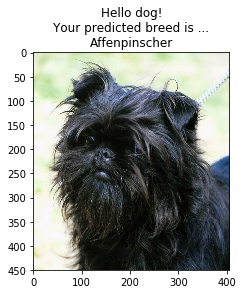

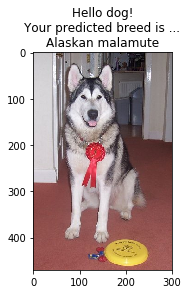

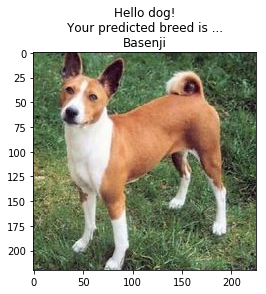

In [72]:
n = [1, 35, 100]
for file in np.hstack((human_files[n], dog_files[n])):
    run_app(file)